# Accessing the Results of an Optimization

We start with some basic, universal loading and setup.
This is the same in all how-tos and tutorials, so that there is a unified set of data to work with.

## Initial FRETBursts analysis, skip to [here](#acbeg) to skip to how to section

> Download the example file here: [HP3_TE300_SPC630.hdf5](https://zenodo.org/record/5902313/files/HP3_TE300_SPC630.hdf5)

First let's import the necessary modules:

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import fretbursts as frb
import burstH2MM as hmm

sns = frb.init_notebook()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7.1).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


Load the data and search for bursts:

In [2]:
filename = 'HP3_TE300_SPC630.hdf5'
# load the data into the data object frbdata
frbdata = frb.loader.photon_hdf5(filename)

Check the alternation period etc.:

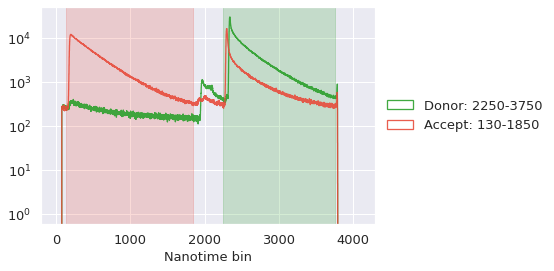

In [3]:
# plot the alternation histogram
frb.bpl.plot_alternation_hist(frbdata)

If the alternation period looks good, we can apply the alternation period to assign Donor/Acceptor excitation to each photon:

In [4]:
# if the alternation period is correct, apply data
frb.loader.alex_apply_period(frbdata)

# Total photons (after ALEX selection):    11,414,157
#  D  photons in D+A excitation periods:    5,208,392
#  A  photons in D+A excitation periods:    6,205,765
# D+A photons in  D  excitation period:     6,611,308
# D+A photons in  A  excitation period:     4,802,849



Calculate the background rates used to set thresholds for finding bursts:

 - Calculating BG rates ... get bg th arrays
Channel 0
[DONE]


<AxesSubplot:title={'center':'HP3_TE300_SPC630'}, xlabel='Inter-photon delays (ms)', ylabel='# Delays'>

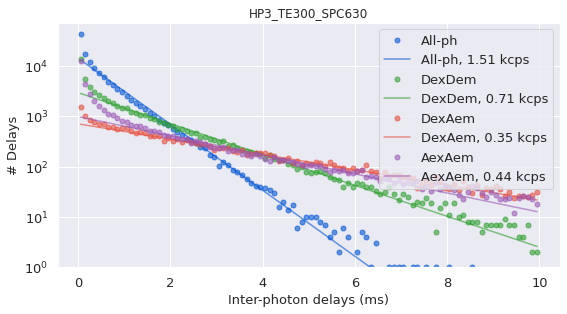

In [5]:
# calcualte the background rate
frbdata.calc_bg(frb.bg.exp_fit, F_bg=1.7)
# plot bg parameters, to verify quality
frb.dplot(frbdata, frb.hist_bg)

And finally search for bursts and refine the selection by appropriate burst size/width/other parameters:

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
<class 'matplotlib.figure.Figure'>


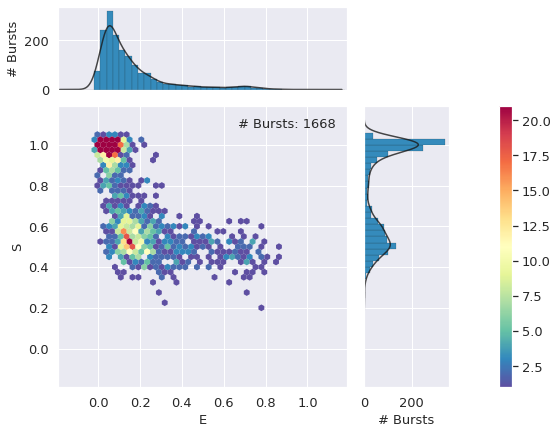

In [6]:
# now perform burst search
frbdata.burst_search(m=10, F=6)
# make sure to set the appropriate thresholds of ALL size
# parameters to the particulars of your experiment
frbdata_sel = frbdata.select_bursts(frb.select_bursts.size, th1=50)

frb.alex_jointplot(frbdata_sel);

Now that the data is selected, we can segment the photons into bursts, which will be stored in a BurstData object:

In [7]:
bdata = hmm.BurstData(frbdata_sel)

<a id="acbeg"></a>

`H2MM_list.calc_models()` is designed to streamline this process, which optimizes models until the ideal model is found (it actually calculates one more than necessary because it must see that there is at least one model with too many models).

So before `H2MM_list.calc_moels()` is called on an `H2MM_list` object, it has no optimizations associated with it. 


In [8]:
try:
    bdata.models[0]
except Exception as e:
    print(e)

No optimizations run, must run calc_models or optimize for H2MM_result objects to exist


After `H2MM_list.calc_models()` is called, then several different state models are stored in the `H2MM_list.opts` attribute, but are also accessible by indexing `H2MM_list`.

In [9]:
# calculate models
bdata.models.calc_models()

bdata.models[0]

The model converged after 1 iterations

The model converged after 36 iterations

The model converged after 122 iterations

The model converged after 414 iterations

The elements within `H2MM_list` are, as you see above, `H2MM_result` objects. 
These serve to organize both the optimized models, and various results we will discuss later in this section. 
But the first thing to examine are the statistical discriminators. 
These take the loglikelihood of the model given the data, and add penalties for the number of states. 
There are 2 primary discriminators:

1. BIC: the Bayes Information Criterion

   Based on the likelihood of the model over all possible state paths through the data, usually found to always improve with more states, and therefore less useful

2. ICL: the Integrated Complete Likelihood

   Based on the likelihood of the most likely state path through the data. 
   Usually is minimized for the ideal state-model, and therefore the preferred statistical discriminator to use.

In both cases, the smaller the better. 
Since these are computed for each optimized model, each `H2MM_result` object (index of `H2MM_list`), has an attribute to get this value. 
However, since these values are generally only useful in relation to other models optimized against the same data, the `H2MM_result` object has its own attribute to return an array with the values of all the optimized models:

1. **BIC**: `H2MM_result.bic`

In [10]:
bdata.models[0].bic

323390.78889950004

1. **BIC** `H2MM_list.BIC`

In [11]:
bdata.models.BIC

array([323390.7888995 , 274041.04580956, 266584.73431315, 265800.67189546])

2. **ICL** `H2MM_result.bic`

In [12]:
bdata.models[0].icl

323390.78889956296

2. **ICL** `H2MM_list.ICL`

In [13]:
bdata.models.ICL

array([323390.78889956, 275340.11281888, 269885.74610546, 271100.67269687])

burstH2MM has an easy way to compare these:

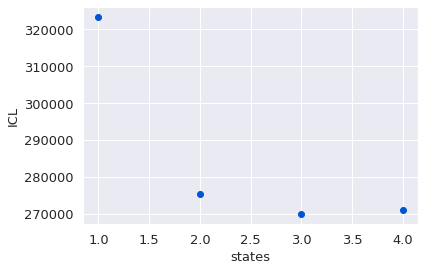

In [14]:
# give ICL_plot a H2MM_list object
hmm.ICL_plot(bdata.models)

Note that we do not index `bdata.models` because this is comparing the different state models, not looking at a single model.

So now that we know how to select the model, what actually composes a `H2MM model`? 
There are three key components:

1. Initial probability matrix (the .prior matrix)
   - The likelihood of a burst beginning in a given state

2. Observation probability matrix (the .obs matrix)
   - Contains probability a given state will emit a photon in a given index, from this the E and S values can be calculated.

3. Transition probability matrix (the .trans matrix)
   - The rate at which each state transitions to the others. This indicates the rate of transitions, characterizing the thermodynamic stability of each state (assuming you are using a model that has an appropriate number of states, over and underfit models will obviously have transition rates not reflective of the actual dynamics).

> **Note**
> 
> The attribute names for the statistical discriminators from `H2MM_list` objects use capital letters, while `H2MM_result` objects are use lowercase letters.

The initial probability matrix does not have a clear physical meaning, but the observation probability and transition probability matrices contain very valuable information. 
burstH2MM automatically converts the values in these from the abstract units of the core algorithm into more human-friendly units (E/S values and transition rates in seconds).

E and S can be accessed with the attributes `H2MM_result.E`:

In [15]:
bdata.models[2].E

array([0.66031034, 0.15955158, 0.06730048])

and `H2MM_result.S`

In [16]:
bdata.models[2].S

array([0.43073408, 0.55348988, 0.9708039 ])

The above values are the raw values, if you want to have them corrected for leakage, direct excitation, and the beta and gamma values, you can access them by adding "`_corr`" to the attribute name, to get `H2MM_result.E_corr` and `H2MM_result.S_corr`.

The transition rates are accessed through the H2MM_result.trans attributes.

In [17]:
bdata.models[2].trans

array([[1.99994147e+07, 5.31727384e+02, 5.35449335e+01],
       [2.05278796e+02, 1.99996914e+07, 1.03279314e+02],
       [7.90906719e+00, 1.16271242e+02, 1.99998758e+07]])

These are in s<sup>-1</sup> and the organization is \[from state, to state\]. 
Notice that the diagonal is all very large values, this is because the diagonal represents the probability that the system remains in the same state from one time step to the next, as the time steps are in the clock rate of the acquisiation (typically 20 mHz, meaning 50 ns from one time step to the next) this is a very large number.

Now H<sup>2</sup>MM also contains the *Viterbi* algorithm, which takes the data and optimized model, and finds the most likely state of each photon. 
burstH2MM continues to perform analysis on this state path to produce a number of usefull parameters to help understand the data.

# Table of Attributes

Below is a list and description of the different possible parameters and their descriptions.



| Attribute            | Description                                                          | Type                        |
|----------------------|----------------------------------------------------------------------|-----------------------------|
| `nanohist`           | Number of photons in each state and TCSPC bin                        | state stream nanotime array |
| `burst_state_counts` | Counts per dwell of states present within bursts                     | state burst array           |
| `burst_type`         | Bininary code specifying the state present within each burst         | burst array                 |
| `trans_locs`         | The location of transitions with bursts                              | burst list                  |
| `burst_dwell_num`    | Duration of each dwell (in ms)                                       | dwell array                 |
| `dwell_state`        | The state of each dwell                                              | dwell array                 |
| `dwell_pos`          | Numerical indicator of location within the burst of each dwell array | dwell array                 |
| `dwell_ph_counts`    | Number of photons in each stream and dwell                           | stream dwell array          |
| `dwell_ph_counts_bg` | Background corrected number of photons in each stream and dwell      | stream dwell array          |
| `dwell_E`            | Raw FRET efficiency (E<sup>raw</sup>) of each dwell                  | dwell array                 |
| `dwell_E_corr`       | Fully corrected FRET efficiency of each dwell (E)                    | dwell array                 |
| `dwell_S`            | Raw stoichiometry (S<sup>raw</sup>) of each dwell                    | dwell array                 |
| `dwell_S_corr`       | Fully corrected stoichiometry of each dwell (S)                      | dwell array                 |
| `dwell_nano_mean`    | Mean nanotime of each stream in each dwell                           | stream dwell array          |

Meaning of “type” explained in next section.

## Understanding dwell array organization

Data in dwell attributes (those that begin with “dwell”) are organized into numpy arrays. 
As diagrammed in the figure below, the dwells are placed in the same order that they in the data. 
This means the consecutive dwells indicate a transition from one state to another. 
However, when one bursts ends, it is generally unreasonable to consider the dwell in the next burst to be considered a transition. 
Hence, special consideration needs to be given for bursts at the start and end of bursts, as well as for bursts which contain only a single state, which is still counted as a dwell. 
Since these are still included in the dwell arrays, the position of a burst within a dwell is recorded in the `H2MM_result.dwell_pos` paremeter.

![dwell_org](https://bursth2mm.readthedocs.io/en/latest/_images/dwellorg.png)

As seen, dwells in the middle of burst are marked with a `0` in `H2MM_result.dwell_pos`, end with a `1`, beginning with a `2` and bursts that span the whole dwell are marked with a `3`. 
The size of `H2MM_result.dwell_pos` and other dwell array parameters match, and therefore `H2MM_result.dwell_pos` can be used to make masks to select only dwells in one of the possible positions.

For instance if you want to get the E values of only dwells that are in the middle of bursts, excluding beginning, ending and whole burst dwells, you could execute the following:

In [18]:
mid_dwell_mask = bdata.models[2].dwell_pos == 0
mid_dwell_E = bdata.models[2].dwell_E[mid_dwell_mask]
print("Middle dwells:")
mid_dwell_E

Middle dwells:


array([0.8       , 0.21875   , 0.55555556, 0.28571429, 0.58823529,
       0.27272727, 0.11111111, 0.85714286, 0.21428571, 0.08108108,
       0.66666667, 0.08571429, 0.58333333, 0.14285714, 0.        ,
       0.        , 0.2       , 0.70588235, 0.        , 0.74193548,
       0.08      , 0.06      , 0.57142857, 0.04651163, 0.63636364,
       0.775     , 0.85714286, 0.07692308, 0.57142857, 0.17021277,
       0.54166667, 1.        , 0.64285714, 0.03846154, 0.7       ,
       0.10526316, 0.        , 0.        , 0.23076923, 0.08108108,
       0.18181818, 0.5       , 0.83333333, 0.70454545, 0.2       ,
       0.07843137, 0.13333333, 0.71428571, 0.06666667, 0.77777778,
       0.875     , 0.14285714, 0.        , 0.76470588, 0.        ,
       0.9       , 0.56      , 0.72      , 0.08108108, 0.35714286,
       0.6       , 0.65909091, 0.13333333, 0.8       , 0.        ,
       0.55555556, 0.16853933, 0.75      , 0.24637681, 0.8       ,
       0.15      , 0.05660377, 0.6875    , 0.8125    ,        

Now some of the dwell parameters have extra dimensions, like `H2MM_result.dwell_nano_mean`, where the mean nanotime is calculate per stream in addition to per dwell. 
Therefore, it is a 2D array, with the last dimension marking the dwell.

Now, to get an accurate `H2MM_result.dwell_nano_mean`, we first need to set the IRF thresholds:

In [19]:
bdata.irf_thresh = np.array([2355, 2305, 220])

So, with the `BurstData.irf_thresh` set, to get the mean nanotimes of the mid-burst dwells, we would execute the following:

In [20]:
mid_dwell_mask = bdata.models[2].dwell_pos == 0
mid_dwell_nano_mean = bdata.models[2].dwell_nano_mean[:, mid_dwell_mask]

mid_dwell_nano_mean

array([[ 5.28919324,  3.02778298,  3.07976408,  4.42869837,  1.83839165,
         2.11497928,  2.99796568,         nan,  2.2720322 ,  3.53096402,
         3.91131565,  5.02676288,  0.80131888,  4.31401096,  2.71656024,
         4.09526792,  3.82860111,  2.19385475,  2.07353476,  2.01958418,
         4.18760187,  3.45690921,  3.24925035,  3.75190694,  3.62486858,
         3.02259003,  4.32826206,  2.81541278,  2.1645382 ,  3.94518814,
         3.23703513,         nan,  1.00572035,  3.84502028,  7.40649924,
         4.2236496 ,  3.95926042,  4.24145992,  3.148314  ,  3.20631198,
         3.42922136,  1.453612  ,  1.36810541,  1.66432466,  3.38972546,
         3.73029762,  3.80175446,  2.98606774,  4.77411784,  1.61851756,
                nan,  2.4286092 ,  4.32317238,  4.07988578,  4.724239  ,
         0.36645681,  0.95957393,  3.37954611,  3.56204741,  4.53795679,
         1.80785358,  2.04944362,  2.21095607,  0.5008243 ,  3.34856546,
         4.11653146,  3.58945354,  2.53313268,  3.0

Of course, you probably want to look at just on photon stream’s nanomean, more often than not this will be the D<sub>ex</sub>D<sub>em</sub> stream, which for this data is the 0th stream. 

So to get this we would execute the following:

In [21]:
mid_dwell_mask = bdata.models[2].dwell_pos == 0
mid_dwell_nano_mean_DD = bdata.models[2].dwell_nano_mean[0, mid_dwell_mask]
mid_dwell_nano_mean_DD

array([ 5.28919324,  3.02778298,  3.07976408,  4.42869837,  1.83839165,
        2.11497928,  2.99796568,         nan,  2.2720322 ,  3.53096402,
        3.91131565,  5.02676288,  0.80131888,  4.31401096,  2.71656024,
        4.09526792,  3.82860111,  2.19385475,  2.07353476,  2.01958418,
        4.18760187,  3.45690921,  3.24925035,  3.75190694,  3.62486858,
        3.02259003,  4.32826206,  2.81541278,  2.1645382 ,  3.94518814,
        3.23703513,         nan,  1.00572035,  3.84502028,  7.40649924,
        4.2236496 ,  3.95926042,  4.24145992,  3.148314  ,  3.20631198,
        3.42922136,  1.453612  ,  1.36810541,  1.66432466,  3.38972546,
        3.73029762,  3.80175446,  2.98606774,  4.77411784,  1.61851756,
               nan,  2.4286092 ,  4.32317238,  4.07988578,  4.724239  ,
        0.36645681,  0.95957393,  3.37954611,  3.56204741,  4.53795679,
        1.80785358,  2.04944362,  2.21095607,  0.5008243 ,  3.34856546,
        4.11653146,  3.58945354,  2.53313268,  3.03955562,  2.31

You could also isolate a particular state using the `H2MM_result.dwell_state` parameter to make another mask:

In [22]:
mid_dwell_mask = bdata.models[2].dwell_pos == 0
state1_mask = bdata.models[2].dwell_state == 1
comb_mask = mid_dwell_mask * state1_mask
state1_mid_nano_mean_DD = bdata.models[2].dwell_nano_mean[0, comb_mask]
state1_mid_nano_mean_DD

array([3.02778298, 4.42869837, 2.11497928, 2.99796568, 2.2720322 ,
       5.02676288, 4.31401096, 3.82860111, 2.07353476, 2.81541278,
       3.94518814, 4.2236496 , 3.95926042, 3.148314  , 3.42922136,
       3.38972546, 3.80175446, 4.77411784, 2.4286092 , 4.724239  ,
       4.53795679, 2.21095607, 3.34856546, 3.58945354, 3.03955562,
       3.02449018,        nan, 8.87436233, 3.71885796, 3.84734405,
       2.78851705, 2.98307204, 3.07300208, 3.01148969, 2.592447  ,
       4.07988578, 1.41696632, 3.71702169, 2.78470157, 1.91168301,
       4.65004946, 3.52616955, 2.72677178, 2.8442686 , 3.78512705,
       4.78022546, 2.91909022, 3.37780107, 3.53630818, 2.31710218,
       4.08865569, 4.30082206, 3.45012297, 3.27368081, 4.35156928,
       1.91473681, 2.93491185, 3.77882742, 2.48672407, 4.7700461 ,
       4.03102487, 5.23563417, 4.52207699, 3.84016195, 2.68522553,
       2.19686157, 3.66224136, 4.1994205 , 4.29823296, 2.87835165,
       3.71081143, 6.46098251,        nan, 1.76347159, 3.36609

Thus you can have a great deal of customization.

### Example: Calculate variance of state 1 dwell E values
Let’s put this into practice. 
Let’s say you want to know how tightly a given state’s dwell cluster around a given value. The steps would be simple:

1. Make mask of dwells in that state

2. Get E values of those dwells using mask

3. Calculate standard deviation (or whatever other value is of interest)

So lets see this in code:

In [23]:
# make mask of dwells in state 1
state1_mask = bdata.models[2].dwell_state == 1
# get E values
state1_E = bdata.models[2].dwell_E[state1_mask]
# calculate standard deviation
np.nanstd(state1_E)

0.12135964925716479

> **Note**
>
> We used np.nanstd, as dwells with no D<sub>ex</sub>D<sub>em</sub> or D<sub>ex</sub>A<sub>em</sub> photons will have nan values, so we must exclude them to get a result that is not nan

# Using masking functions to make masks

burstH2MM also provides a set of masking functions in `burstH2MM.Masking`. 
They are named descriptively, and simply take a `H2MM_list` object as input. 
So we can get the mid dwell mask like this:

In [24]:
mid_dwell_mask = hmm.mid_dwell(bdata.models[2])
mid_dwell_mask

array([False, False,  True, ..., False, False, False])

These functions can be used to filter which dwells are shown in various plotting functions, which is their primary use in burstH2MM. See Plotting only dwells of certain position and other masking for a demonstration of thier use in plotting.

# Burst Based Arrays

In the list of attributes, you will notice two burst as opposed to dwell based attributes `H2MM_result.burst_state_counts` and `H2MM_result.burst_type`

These arrays are based not on dwells, but on the bursts instead. 
`H2MM_result.burst_state_counts` is the larger, but ironically easier to understand of these arrays. 
Going down the rows, you go through different states, each element indicating the number of dwells in that state, each column a different state.

In [25]:
bdata.models[2].burst_state_counts

array([[0, 2, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 1],
       [1, 0, 1, ..., 1, 1, 1]])

So for instance, the `H2MM_result.burst_state_counts` \[1,23\] will tell you how many dwells there were in state 1 burst 23.

`H2MM_result.burst_type` is essentially a simplification of `H2MM_result.burst_state_counts` where it no longer matters how many dwells in a given state are present, just whether there is at least one instance of a given state. 
It represents this in a binary form, so a burst with only State0 will take the value `0b1`, while only State1 will have `0b10`, and a dwell with transitions between State0 and State1 will be represented as `0b11`. 
Of course, python usually doesn’t display things in binary, so these will become 1, 2 and 3 when acutally displayed.

In [26]:
bdata.models[2].burst_type

array([4, 3, 4, ..., 4, 4, 6])